## Table of Contents:
1. [Problem Description](#problem-description)
2. [Getting the input data](#input-data)
3. [Construct PyPSA model](#pypsa-model)


In [1]:
import pypsa
import random
import pandas as pd
import matplotlib.pyplot as plt

## 1. Problem Description <a class="anchor" id="problem-description"></a>

In this example, we are going to build a super simple illustrative power model for Singapore (SGP) using PyPSA. 

This notebook will help you to:

1. Understand how to make PyPSA models.
2. Understand the components of the PyPSA framework.

Our super simple model for SGP is illustrated below. As we can see, we are imagining that SGP's power generation system is made up of a single fossil (gas) power plant and a solar farm. The outpot from these two plants is pooled in the local balancing zone and distributed to the whole country. Clearly, this is just an illustrative model and the real-world system is far more complex. However, these types of "lumped flow models" can be quite useful to a modeller/analyst when testing out scenarios and methodologies. 

<div>
<img src="../img/toy_model_sgp.png" width="500"/>
</div>


## 2. Get the input data <a class="anchor" id="input-data"></a>
For these demos, all of our input data is contained within a Microsoft Excel file (`data/system_inputs.xlsx`). As you will see in the excel, the input data is separated into three sections: 

1. **Forcing data:** Hourly resolution data that are fed _exogenously_ into the model and are the major driver in the optimisation.
2. **System data:** Parameters related to the power system (e.g., capacities, demands, locations etc.)
3. **Assumptions:** Assumed parameters related to technologies (e.g., efficiencies, costs etc.)

We can read the whole excel file into a single Python class as below.

In [2]:
class LoadExcel():

    def __init__(
            self, 
            path_to_file = '../data/system_inputs.xlsx',
            country_iso = None,
    ):
        
        from openpyxl import load_workbook

        sheetnames = load_workbook(filename = '../data/system_inputs.xlsx').sheetnames
        sheetnames = [i for i in sheetnames if '>' not in i]

        for sheet in sheetnames:
            # read data
            df = pd.read_excel(path_to_file, sheet_name=sheet)
        
            # snapshot as index
            if 'snapshot' in df.columns:
                df['snapshot'] = pd.to_datetime(df['snapshot'])
                df = df.set_index('snapshot')

                if country_iso is not None:
                    try:
                        df = df[country_iso]
                    except:
                        pass
            
            # filter regions
            if not country_iso:
                pass
            else:
                try:
                    df = df.loc[ df.iso.isin(country_iso) ].reset_index(drop=True)
                except:
                    pass

            setattr(self, sheet, df.copy())


# let's get our input data for a 48 hour (2-day) simulation
input_data = LoadExcel(country_iso=['IND'])

<Axes: xlabel='snapshot'>

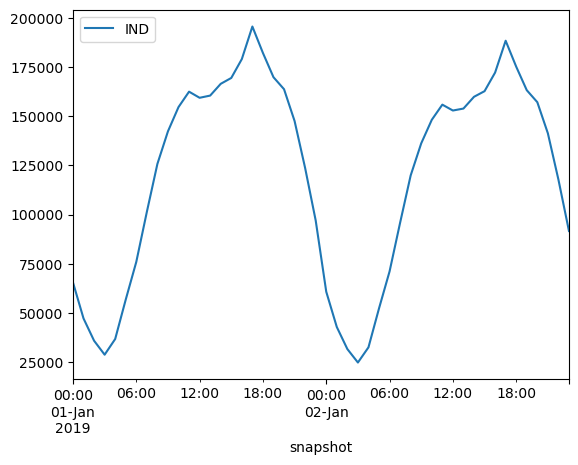

In [3]:
input_data.load_profile.iloc[0:48].plot()

In [4]:
import plotly.express as px

px.bar( 
    data_frame = input_data.generation,
    x = 'iso',
    y = 'capacity',
    color = 'variable',
    width=400, 
    height=400
)

In [5]:
input_data.buses

,country,iso,longitude,latitude
0,india,IND,78.9629,20.5937


## 3. Construct the PyPSA model <a class="anchor" id="pypsa-model"></a>


In [6]:
input_data.solar

,capacity_factor
snapshot,
2019-01-01 00:00:00,0.119
2019-01-01 01:00:00,0.267
2019-01-01 02:00:00,0.387
2019-01-01 03:00:00,0.417
2019-01-01 04:00:00,0.423
...,...
2019-12-31 19:00:00,0.000
2019-12-31 20:00:00,0.000
2019-12-31 21:00:00,0.000


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.solvers:Log file at /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 336 primals, 720 duals
Objective: 0.00e+00
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
48 rows, 96 cols, 96 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-720); columns 0(-336); elements 0(-1008) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  0.0000000000e+00
HiGHS run time      :          0.00


<Axes: xlabel='snapshot'>

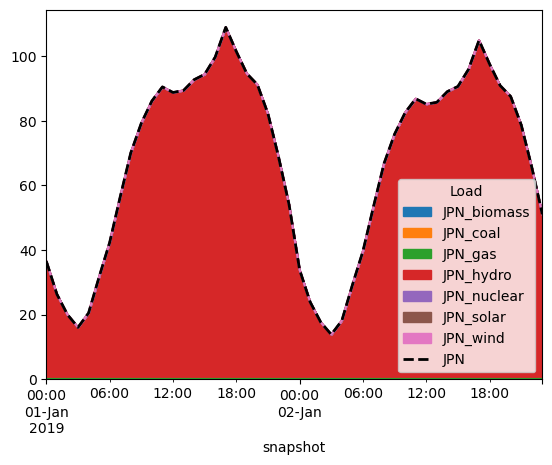

In [11]:
def construct_pypsa_model(country_iso, timesteps, p_nom_extendable=True):

    # load data directly in model constructor
    input_data = LoadExcel(country_iso=country_iso)

    # initiate blank pypsa network
    network = pypsa.Network()

    # define our hourly timesteps (referred to as snapshots)
    network.set_snapshots(input_data.load_profile.iloc[0:timesteps].index)

    # add buses
    for _, row in input_data.buses.iterrows():

        network.add(
            "Bus",  # PyPSA component
            row['iso'], # bus name
            x = row['longitude'], # longitude
            y = row['latitude'], # latitude
        )

    # setup energy carriers
    emissions_dict = input_data.technology_params[
        input_data.technology_params['Row Labels'].isin(input_data.generation.variable.unique().tolist())
        ].set_index('Row Labels')['CO2 intensity'].fillna(0).to_dict()
    
    network.madd(
        'Carrier', # PyPSA component
        input_data.generation.variable.unique().tolist(), # carriers
        co2_emissions=emissions_dict, # co2/mwh
        #nice_name=['Natural Gas', 'Solar PV'], # verbose names
        #color=['grey', 'yellow'], # colours for plotting
    )

    # define the demand curve
    for col in input_data.load_profile.columns:

        network.add(
                "Load", 
                col, 
                bus=col, 
                p_set=input_data.load_profile[col].iloc[0:timesteps],
            )

    # now let's add our generators
    for _, row in input_data.generation.iterrows():
        
        if row['variable'] in ['solar','wind']:

            if row['variable'] == 'solar':
                capacity_factor = input_data.solar.iloc[0:timesteps].capacity_factor
            else:
                capacity_factor = input_data.wind.iloc[0:timesteps].capacity_factor

            network.add(
                'Generator', # PyPSA component
                row['iso'] + '_' + row['variable'], # generator name
                bus = row['iso'], # balancing zone
                carrier = row['variable'],
                p_nom = row['capacity'] * 1e3, # starting capacity (GW -> MW)
                p_nom_extendable = p_nom_extendable, # let's allow the model to build more solar
                p_max_pu=capacity_factor, # here's where we feed in our solar profile
                marginal_cost = row['marginal_cost'],
                capital_cost = row['capital_cost'],
            )

        else:
            network.add(
                'Generator', # PyPSA component
                row['iso'] + '_' + row['variable'], # generator name
                bus = row['iso'], # balancing zone
                carrier = row['variable'],
                p_nom = row['capacity'] * 1e3, # starting capacity (GW -> MW)
                marginal_cost = row['marginal_cost'],
                p_nom_extendable = False, # can the model build more? let's say yes in this case
            )
    
    # finally, let's add storage units
    
    return network

sgp_model = construct_pypsa_model(country_iso=['SGP'], timesteps=48, p_nom_extendable=False)

sgp_model.optimize(solver_name='highs')

# let's look at the dispatch as a time series
f,ax = plt.subplots(nrows=1,ncols=1)

# dispatch by carrier
sgp_model.generators_t.p.plot.area(stacked=True,ax=ax)

# demand
sgp_model.loads_t.p.plot(color='black',linewidth=2,linestyle='--',ax=ax,label='Demand')


In [8]:
input_data = LoadExcel(country_iso=['IND'])

In [9]:
input_data.load_profile

,IND
snapshot,
2019-01-01 00:00:00,65552.652182
2019-01-01 01:00:00,47267.567039
2019-01-01 02:00:00,35948.228616
2019-01-01 03:00:00,28858.093560
2019-01-01 04:00:00,36818.946956
...,...
2019-12-31 19:00:00,164938.931298
2019-12-31 20:00:00,158843.902916
2019-12-31 21:00:00,143046.584459


In [10]:
# create network class
network = pypsa.Network()

# define our hourly timesteps (referred to as snapshots)
network.set_snapshots(demand.index)

# define the singapore bus (i.e., the balancing zone)
network.add(
    "Bus",  # PyPSA component
    sgp['iso'], # bus name
    x = sgp['x'], # longitude
    y = sgp['y'], # latitude
)

# setup the generation technologies (referred to as carriers) we have
network.madd(
    'Carrier', # PyPSA component
    ['gas', 'solar'], # carriers
    co2_emissions={'gas' : 0.2, 'solar' : 0}, # co2/mwh
    nice_name=['Natural Gas', 'Solar PV'], # verbose names
    color=['grey', 'yellow'], # colours for plotting
)

# define the demand curve
network.add(
        "Load", 
        sgp['name'], 
        bus=sgp['iso'], 
        p_set=demand['singapore'],
    )

# ---
# now let's add our two generators

# (1) gas
network.add(
    'Generator', # PyPSA component
    'sgp_gas', # generator name
    bus = sgp['iso'], # balancing zone
    carrier = 'gas',
    p_nom = 100, # starting capacity
    marginal_cost = 50,
    p_nom_extendable = True, # can the model build more? let's say yes in this case
)

# (2) solar
network.add(
    'Generator', # PyPSA component
    'sgp_solar', # generator name
    bus = sgp['iso'], # balancing zone
    carrier = 'solar',
    p_nom = 200, # starting capacity
    p_nom_extendable = True, # let's allow the model to build more solar
    p_max_pu=res_profiles['solar'], # here's where we feed in our solar profile
    marginal_cost = 0,
    capital_cost = 5,
)

NameError: name 'demand' is not defined

That's it! We've setup the super simple model 🎉 Let's take a look at our work...

In [ ]:
network.buses

In [ ]:
network.snapshots

In [ ]:
network.loads_t.p_set

### Step (3): Run optimisation (i.e., let's solve the model)

In [ ]:
network.optimize(solver_name='highs')

### Step (4): Explore our results

<Axes: xlabel='snapshot'>

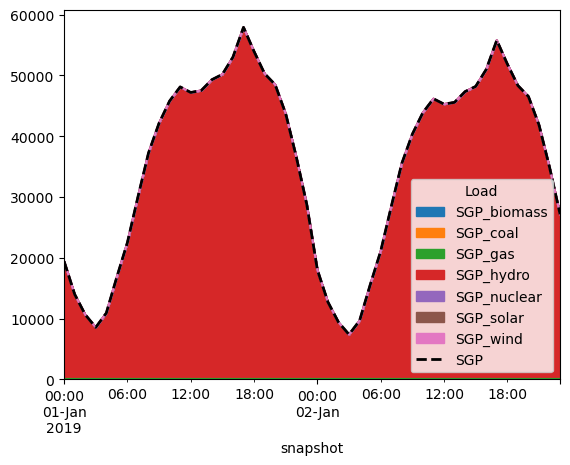

We can also get several statistics directly from PyPSA. Let's explore these:

In [ ]:
# total dispatch by carrier
network.statistics.dispatch()

In [ ]:
# total curtailment by carrier
network.statistics.curtailment()

In [ ]:
# energy balance by carrier and loads (i.e. input vs output)
network.statistics.energy_balance()

In [ ]:
# capacity expansion
network.statistics.expanded_capacity()